In [43]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/72.0 MB ? eta -:--:--
                                             0.0/72.0 MB 330.3 kB/s eta 0:03:38
                                             0.0/72.0 MB 325.1 kB/s eta 0:03:42
                                             0.0/72.0 MB 245.8 kB/s eta 0:04:53
                                             0.0/72.0 MB 245.8 kB/s eta 0:04:53
                                             0.2/72.0 MB 817.0 kB/s eta 0:01:28
                                             0.2/72.0 MB 942.1 kB/s eta 0:01:17
                                             0.3/72.0 MB 948.8 kB/s eta 0:01:16
                                              0.4/72.0 MB 1.0 MB/s eta 0:01:11
                                              0.4/72.0 MB 1.0 MB/s eta 0:01:11
                                              0.5/72.0 MB 1.0 MB/s eta 0:01:12
                                              0.5/72.


[notice] A new release of pip is available: 23.1.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
df = pd.read_csv('Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.shape

(13320, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [6]:
df.duplicated().sum()

529

In [7]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [8]:
df=df.drop('society',axis=1)
df= df.dropna(subset=['location', 'size', 'bath'])
df['balcony'] = df['balcony'].fillna(df['balcony'].median())
df = df.drop_duplicates()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12677 entries, 0 to 13318
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     12677 non-null  object 
 1   availability  12677 non-null  object 
 2   location      12677 non-null  object 
 3   size          12677 non-null  object 
 4   total_sqft    12677 non-null  object 
 5   bath          12677 non-null  float64
 6   balcony       12677 non-null  float64
 7   price         12677 non-null  float64
dtypes: float64(3), object(5)
memory usage: 891.4+ KB


In [10]:
df.duplicated().sum()

0

In [11]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        try:
            return (float(tokens[0].strip()) + float(tokens[1].strip())) / 2
        except:
            return None
    try:
        return float(x)
    except:
        return None

In [12]:
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

In [13]:
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df = df.dropna(subset=['total_sqft'])

In [14]:
df['price_per_sqft'] = df['price']*100000/df['total_sqft']

In [15]:
df['availability'] = df['availability'].apply(lambda x:1 if 'Ready To Move' in x else 0)

In [16]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [17]:
df['location'] = df['location'].apply(lambda x: x.strip())

In [18]:
location_stats = df['location'].value_counts()
location_stats_less_than_10 = location_stats[location_stats <= 10]
df['location'] = df['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

In [19]:
df = df[~(df.total_sqft / df.bhk < 300)]

In [20]:
df = remove_pps_outliers(df)

In [21]:
df = df[df.bath < df.bhk + 2]

In [22]:
y = df['price']
x = df.drop(['price','price_per_sqft','size'],axis=1)
print('Features being used:',x.columns.to_list())
print(x.shape)
print(y.shape)

Features being used: ['area_type', 'availability', 'location', 'total_sqft', 'bath', 'balcony', 'bhk']
(9712, 7)
(9712,)


In [23]:
categorical_cols = ['area_type','location']
numerical_cols = ['total_sqft','bath','balcony','bhk','availability']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num',  'passthrough', numerical_cols)
    ])
lr_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                             ('regressor',LinearRegression())])

In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)
print(f"Training samples: {len(x_train)}")
print(f"Test samples:     {len(x_test)}")
lr_pipeline.fit(x_train,y_train)

Training samples: 7769
Test samples:     1943


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [25]:
y_pred = lr_pipeline.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)
print("Linear Regression Performance on test set:")
print(f"RMSE: {rmse:8.2f} lakhs")
print(f"MAE:  {mae:8.2f} lakhs")
print(f"R²:   {r2:8.4f}")

Linear Regression Performance on test set:
RMSE:    31.94 lakhs
MAE:     19.08 lakhs
R²:     0.8138


In [40]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),   
    ('regressor', RandomForestRegressor(
        n_estimators=300,         
        max_depth=18,            
        min_samples_split=10,
        min_samples_leaf=5,
        max_features=0.5,        
        random_state=42,
        n_jobs=-1                
    ))
])

In [37]:
rf_pipeline.fit(x_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [38]:
y_pred_rf = rf_pipeline.predict(x_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

print("Random Forest Performance on test set:")
print(f"RMSE: {rmse_rf:8.2f} lakhs")
print(f"MAE:  {mae_rf:8.2f} lakhs")
print(f"R²:   {r2_rf:8.4f}")

Random Forest Performance on test set:
RMSE:    34.95 lakhs
MAE:     19.64 lakhs
R²:     0.7771


In [39]:
print("Comparison:")
print(f"Linear Regression → R²: {r2:7.4f} | RMSE: {rmse:6.2f} | MAE: {mae:6.2f}")
print(f"Random Forest     → R²: {r2_rf:7.4f} | RMSE: {rmse_rf:6.2f} | MAE: {mae_rf:6.2f}")

Comparison:
Linear Regression → R²:  0.8138 | RMSE:  31.94 | MAE:  19.08
Random Forest     → R²:  0.7771 | RMSE:  34.95 | MAE:  19.64


In [45]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',XGBRegressor(n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1))
])

In [46]:
xgb_pipeline.fit(x_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [48]:
y_pred_xgb = xgb_pipeline.predict(x_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb  = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb   = r2_score(y_test, y_pred_xgb)

print("XGBoost Performance on test set:")
print(f"RMSE: {rmse_xgb:8.2f} lakhs")
print(f"MAE:  {mae_xgb:8.2f} lakhs")
print(f"R²:   {r2_xgb:8.4f}")

XGBoost Performance on test set:
RMSE:    29.55 lakhs
MAE:     17.67 lakhs
R²:     0.8406


In [49]:
print("Model Comparison:")
print(f"Linear Regression  → R²: {0.8138:.4f} | RMSE: {31.94:.2f} | MAE: {19.08:.2f}")
print(f"Random Forest      → R²: {0.7771:.4f} | RMSE: {34.95:.2f} | MAE: {19.64:.2f}")
print(f"XGBoost            → R²: {r2_xgb:.4f} | RMSE: {rmse_xgb:.2f} | MAE: {mae_xgb:.2f}")

Model Comparison:
Linear Regression  → R²: 0.8138 | RMSE: 31.94 | MAE: 19.08
Random Forest      → R²: 0.7771 | RMSE: 34.95 | MAE: 19.64
XGBoost            → R²: 0.8406 | RMSE: 29.55 | MAE: 17.67


In [50]:
import joblib
joblib.dump(xgb_pipeline,'bengaluru_house_price_xgboost.pkl')


['bengaluru_house_price_xgboost.pkl']

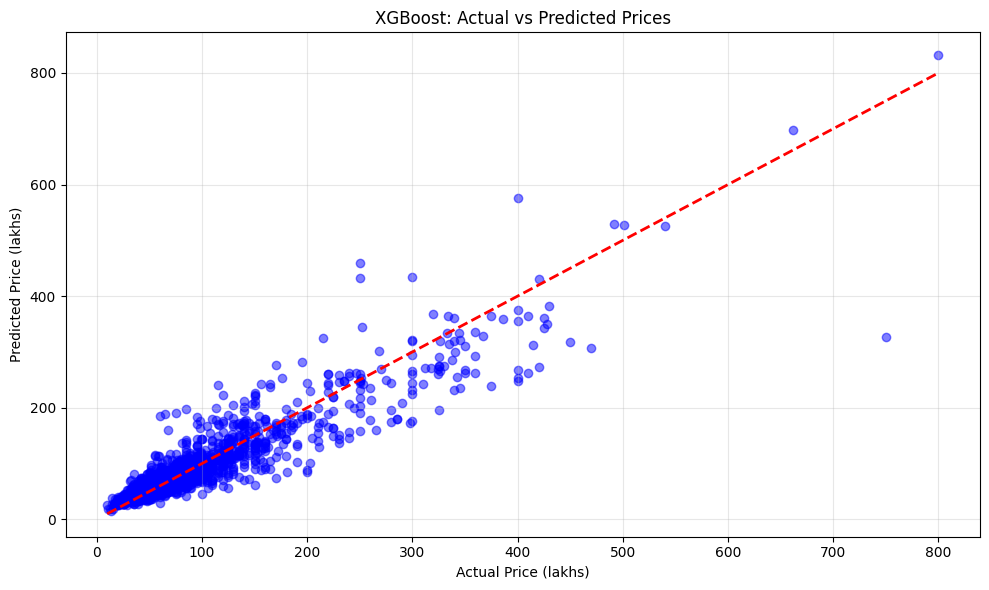

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (lakhs)')
plt.ylabel('Predicted Price (lakhs)')
plt.title('XGBoost: Actual vs Predicted Prices')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

🏠
